## Lecture 6.3 Bernoulli Naive Bayes

### Objective
In this notebook we will implement Naive Bayes Classifier from scratch

In [1]:
import numpy as np

### Naive Bayes Classifier
- Naive Bayes is a **generative classifier**.
- It **estimates probability** of a sample belonging to a class using **Bayes Theorem**:
$$
\begin{align}
    \text{posterior} &= \frac{\textcolor{blue}{\text{prior}} \times \textcolor{purple}{\text{likelihood}}}{\text{evidence}} \\
    p(y|\textbf{x}) &= \frac{\textcolor{blue}{p(y)} \times \textcolor{purple}{p(\textbf{x}|y)}}{p(\textbf{x})}
\end{align}
$$
- It simplifies the calculation of **likelihood** with **conditional independence assumption**: Naive Bayes assumes that the features are *conditionally independent given labels*.
  - The **likelihood** can be expressed as:
$$
\begin{align}
    p(\textbf{x}|y) &= p(x_1, x_2, ... , x_m | y) \\
    &= p(x_1|y) p(x_2|y)...p(x_m|y) \\
    &= \prod_{j=1}^m p(x_j|y)
\end{align}
$$
  - Substituting likelihood in the Bayes theorem gives us the formula:
$$
p(y = y_c | \textbf{x}) = \frac{\textcolor{green}{\prod_{j=1}^m p(x_j|y)}}{\textcolor{red}{\sum_{r=1}^k p(y_r)\prod_{j=1}^m p(x_j|y_r)}}
$$
$\text{where \textit{k} is number of labels, \textit{m} is number of features and \textit{c} is the c-th label in the given \textit{k} labels}$

#### Inference
- We perform this calculation in **log-space** to avoid issues with underflow due to multiplication of small numbers:
  - The label that results in the **highest value of the numerator** i.e $\text{\textcolor{blue}{likelihood}} \times \text{\textcolor{blue}{prior}}$ is assigned to the given example. *Note that the evidence is fixed for all the labels and acts as normalizing constant*.
$$
y = \text{argmax}_y \log p(y) + \sum_{j=1}^m\log p(x_j | y)
$$
- Posterior probability however needs full calculation of the Bayes formula:
  - We first obtain the product of likelihood and prior for each label in log space:
  $$
  \textcolor{blue}{\log p(\textbf{x}, y_r) = \log p(y_r) + \sum_{j=1}^m \log p(x_j + y_r)}
  $$
    and convert that to probability by taking
  $$
  p(\textbf{x}, y_r) = \textcolor{red}{\exp(\log p(\textbf{x}, y_r))}
  $$
  - Sum up these probabilities for obtaining the evidence or the denominator of the formula.
  $$
  p(\textbf{x}) = \sum_{r=1}^k p(\textbf{x}, y_r) = \sum_{r=1}^k \exp(\log p(\textbf{x}, y_r))
  $$
  - Substituting these values one can obtain the posterior probability.
  $$
  p(y_r |\textbf{x}) = \frac{p(\textbf{x},y_r)}{p({\textbf{x}})}
  $$

Naive Bayes classifier is used in **document classification** and **spam filtering**.


#### Learning Problem
- $k$ prior probabilities to be estimated : $\{p(y_1), p(y_2),...,p(y_k)\}$
- $k \times m$ class probabilities: $\{p(x_1|y_1),....,p(x_m|y_1),p(x_1|y_2),...,p(x_m|y_2),....,p(x_1|y_k),....,p(x_m|y_k)\}$

The class conditional densities depend on the nature of the features.
The following are some popular class conditional densities that are used in NB classifier:
- **Bernoulli distribution**: When $x_j$ is a **binary feature**, we use a Bernoulli distribution to model the class conditional density: $p(x_j|y_c)$.
- **Categorical distribution**: When $x_j$ is a **categorical feature** i.e it takes one of the $e >2$ discrete values [e.g {red, green, blue} or roll of a dice], we use categorical distribution to model the class conditional density $p(x_j|y_c)$.
- **Multinomial distribution**: When $\textbf{x}$ is a count vector i.e in each component $x_j$ is a count of appearance in the object it represents and $\sum x_j = l$, which is the length of the object, we use multinomial distribution to model $p(\textbf{x}|y_c)$.
- **Gaussian distribution**: When $x_j$ is a **continuous feature** i.e it takes real values, we use gaussian (normal) distribution to model the class conditional density $p(x_j|y_c)$.

We will implement these different class conditional densities in different NB implementations.

### Bernoulli NB: Implementation

#### Parameter estimation: class conditional density and prior

Remember that the **class conditional density** for Bernoulli NB is calculated as follows:
$$
\large
w_{jy_c} = \frac{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c)x_j^{(i)}}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c)}
$$
What does it mean? **Average of feature value $x_j$ in the examples with label $y_c$**.
- $\mathbb{1}(y^{(i)} = y_c)$ gets us the examples with label $y_c$.
- Numerator sums up $x_j$ across all examples with label $y_c$.
- And is divided by total number of examples with label $y_c$.

The class **prior** is obtained as follows:
$$
\large
w_{y_c} = \frac{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c)}{n}
$$
Here,
- The numerator us **total number of examples with label** $y_c$ and is divided by the **total number of examples in the training set**.

While estimating parameters of the model, we process examples from each label separately and estimate the parameters.

In [2]:
def fit (X, y):
    n_samples, n_features = X.shape
    class_count = np.unique(y)
    n_classes = len(class_count)

    # Initialize the weight vector.
    w = np.zeros((n_classes, n_features), dtype=np.float64)
    w_priors = np.zeros(n_classes, dtype=np.float64)

    for c in range(n_classes): # Preprocessing the examples from each class separately.
        # get examples with label = c
        X_c = X[y == c]

        # estimation of w_{jy_c}: The parameter of Bernoulli distribution
        # p(x_j|y_c) - Ber(w_{jy_c})
        # We have vectorized this operation and we obtain vector w_{y_c} that
        # contains w_{jy_c} for each x_j.
        w[c, :] = np.sum(X_c, axis=0)/X_c.shape[0]

        #estimation of prior probability: w_{y_c}
        w_priors[c] = X_c.shape[0]/np.float64(n_samples)

    print('Weight Vector:', w)
    print('Prior:', w_priors)
    return w, w_priors

Let's look at the parameter estimation in step by step manner:

In [3]:
# feature matrix with shape (4, 2). x_1 - Ber(w_1), x_2 - Ber(w_2)
X = np.array([[1,0],[0,1],[0,1],[1,0]])

# Label vector with shape (4,)
y = np.array([1, 0, 0, 1])

# call fit with feature matrix  and label vector as arguments.
fit(X, y)

#Returns the parameters of bernoulli distributions and priors.

Weight Vector: [[0. 1.]
 [1. 0.]]
Prior: [0.5 0.5]


(array([[0., 1.],
        [1., 0.]]),
 array([0.5, 0.5]))

A few observations:
- Since there are 50% examples of each class 1 and 0, the prior probability vector has 0.5 for each class.
- Note that:
  - For class 0, $x_1 = 0 $ and $x_2 = 1$  and hence the parameters of bernoulli distributions are 0 and 1 respectively.
    - $w_01 = 0, w_02 = 1$.
  - For class 1, $x_1 = 1$ and $x_2 = 0$ and hence the parameters of bernoulli distributions are 1 and 0 respectively.
    - $w_11 = 1, w_12 = 0$.

Let's understand class conditional density calculation step by step:

**STEP 1**: Filter examples for a class, say c=1

In [4]:
X_c = X[y==1]; X_c

array([[1, 0],
       [1, 0]])

**STEP 2**: Feature wise sum.

In [5]:
np.sum(X_c, axis=0)

array([2, 0])

**STEP 3**: Dividing by the class count

In [6]:
w = np.sum(X_c, axis=0)/X_c.shape[0]
w

array([1., 0.])

#### Incorporating Laplace Correction
As we talked in the lecture slides, the 0 value for parameter is a problem as it leads to 0 posterior probability. We can fix this problem with **Laplace correction** or by adding small dummmy counts in each class feature.
- The **class priors** with laplace correction can be calculated as follows:
$$
p (y = y_c)  = \frac{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c) + \alpha}{n + k\alpha}
$$
- The **class conditional density** with laplace correction is computed as follows:
$$
\large
w_{jy_c} = \frac{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c)x_j^{(i)} + \alpha}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_c) + 2\alpha}
$$
In both cases, we use $\alpha =1$ (**Laplace correction or smoothing**)

#### Inference

#### Determine the class label
Remember that we assign class label $y_c$ that results in the largest product of likelihood and prior.
$$
\large
\begin{align}
    y_c &= \text{argmax}_{y_c} \left( \sum_{j=1}^m \log p(x_j|y_c; \mathbf{w}) \right) + \log p(y_c; \mathbf{w}) \\
    &= \text{argmax}_{y_c} \left(\sum_{j=1}^m \log w_{jy_c}^{x_j}(1 - w_{jy_c})^{1 - x_j} \right) + \log p(y_c; \mathbf{w}) \\
    &= \text{argmax}_{y_c} \left(\sum_{j=1}^m x_j\log w_{jy_c} + (1 - x_j)\log (1 - w_{jy_c}) \right) + \log p(y_c; \mathbf{w})
\end{align}
$$
Note that we perform these computations in log space to avoid problem with the underflow.

Further with vectorization, this is implemented as follows:
$$
\large
\mathbf{y} = \text{argmax}_{y}\mathbf{X} \log \mathbf{w}^T + (1 - \mathbf{X})\log (1 -\mathbf{w})^T + \log \mathbf{w}_{\text{prior}}
$$

#### Implementation

In [7]:
class BernoulliNB (object):
    def __init__(self, alpha = 1.0):
        self.alpha = alpha
    
    def fit(self, X, y):
        n_samples , n_features = X.shape
        class_count = np.unique(y)
        n_classes = len(class_count)

        self.w = np.zeros((n_classes, n_features), dtype = np.float64)
        self.w_priors = np.zeros(n_classes, dtype = np.float64)

        for c in range(n_classes):
            X_c = X[y==c]
            self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha)/(X_c.shape[0] + 2 * self.alpha)
            self.w_priors[c] = (X_c.shape[0] + self.alpha)/(float(n_samples) + n_classes * self.alpha)
        
        print('Class conditional density:', self.w)
        print('Prior: ', self.w_priors)
    
    def log_likelihood_prior_prod(self, X):
        return X @ (np.log(self.w).T) + (1 - X) @ np.log((1 - self.w).T) + np.log(self.w_priors)
    
    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q)/np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)
    
    def predict(self, X):
        return np.argmax(self.log_likelihood_prior_prod(X), axis=1)

#### Demo

#### Binary Classification setup

In [8]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density: [[0.25 0.75]
 [0.75 0.25]]
Prior:  [0.5 0.5]


In [9]:
# Let's predict classes for input example.
bernoulli_nb.predict(X)

array([1, 0, 0, 1])

In [10]:
# The class labels are inferred by selecting the label that results into
# Highest value of product of likelihood and priors:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

Observe that based on this calculation, the first example gets class 1, the second one gets 0, third also gets 0 and last one gets class 1.

In [11]:
# Let's predict the probabilities for each example.
bernoulli_nb.predict_proba(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

#### Multiclass classification setup
The NB implementation also works in multiclass setting. Here's an example with three classes.

In [12]:
X = np.array([[1, 0], [0, 1], [0, 1], [1, 0], [1, 1], [1, 1]])
y = np.array([1, 0, 0, 1, 2, 2])

Estimation of parameters of Bernoulli distribution and class priors

In [13]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class conditional density: [[0.25 0.75]
 [0.75 0.25]
 [0.75 0.75]]
Prior:  [0.33333333 0.33333333 0.33333333]


In [14]:
# Let's predict classes for each example.
bernoulli_nb.predict(X)

array([1, 0, 0, 1, 2, 2])

In [15]:
# Let's predict the probabilities for each example.
bernoulli_nb.predict_proba(X)

array([[0.07692308, 0.69230769, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.69230769, 0.07692308, 0.23076923],
       [0.07692308, 0.69230769, 0.23076923],
       [0.2       , 0.2       , 0.6       ],
       [0.2       , 0.2       , 0.6       ]])

## Lecture 6.4: Gaussian Naive Bayes Implementation

### Parameterization
Here the features have real numbers or continuous values. And we assume that **each feature given label is drawn from a gaussian distribution**.

Formally we write it as 
$$
x_j|y_r \sim \mathcal{N}(\mu, \sigma^2)
$$
There are **two parameters** in Gaussian or normal distribution $\mathcal{N}$:
- Mean $\mu$
- Variance $\sigma^2$

There are $m \times k$ ** Gaussian distributions - one for each feature and label.

Each Gaussian distribution has **2 parameters** to estimate hence the **total number of parameters** are $2 \times m \times k$.

### Alternate parameterization through Multi-variate Gaussian
Alternatively, for each label, we can assume a multi-variate Gaussian distribution with $m$ variables. Such a distribution will have
- a **mean vector** ($\mu$) with $m$ components - one mean per feature.
- a **covariance matrix** ($\Sigma$) with $m \times m$ entries-
  - However since we are making a conditional independence assumptions among variables, The covariance matrix is assumed to be diagonal-
    - It's off-diagonal entries are 0 $\Sigma_{jr} = 0$ where $j \ne r$.
    - The diagonal entries denote variance for each feature $\Sigma_{jj} = \sigma^2$

In this scheme, we need to estimate $k$ multi-variate Gaussian distributions, one per label.
For each distribution, we need to estimate
- $m$ means
- $m$ variances

As such the number of parameters are the same in both the representations. However the later representation is more efficient in terms of computation.

### Parameter estimation
Let $n_r$ is the **total number of samples with label** $y_r$
$$
n_r = \sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)
$$
The parameters for **multivariate Gaussian** for label $r$ can be calculated as follows:
$$
\large
\begin{align}
    \mu_{r} &= \frac{1}{n_r} \sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)\mathbf{x}^{(i)} \\
    \Sigma_{jjr}^2 &= \frac{1}{n_r} \sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)(\mathbf{x}^{(i)} - \mu_r)^2
\end{align}
$$

### Inference
The posterior probability can be calculated based on Bayes theorem:
$$
p(y = y_c|\mathbf{x}) = \frac{p(\mathbf{x}|y_c)p(y_c)}{p(\mathbf{x})}
$$
The likelihood is computed with the folllowing formula:
$$
\large
p(x_j|y_c;\mu_{jc},\sigma_{jc}^2) = \frac{1}{\sqrt{2\pi}\sigma_{jc}}e^{-\frac{1}{2}(\frac{x_j - \mu_{jc}}{\sigma_{jc}})^2}
$$
This can be implemented with multi-variate  Gaussian distribution with diagonal covariance matrix:
$$
\large
p(\mathbf{x}|y_c;\mu_c,\Sigma_c) = \frac{1}{(2\pi)^{\frac{d}{2}}|\Sigma_c|^{\frac{1}{2}}} e^{-\frac{1}{2}(\mathbf{x}-\mu_c)^T \Sigma_c^{-1}(\mathbf{x} - \mu_c)}
$$
It is interesting to note that
- We calculate the distance between the mean and the sample normalized by the variance : $\large -\frac{1}{2}(\mathbf{x}-\mu_c)^T \Sigma_c^{-1}(\mathbf{x} - \mu_c)$


- We calculate the exponential of this distance and convert it into probability by dividing it with $\large {(2\pi)^{\frac{d}{2}}|\Sigma_c|^{\frac{1}{2}}}$

Here $d$ is number of dimensions which in this case is $n$ the number of examples

### Implementation

In [16]:
class GaussianNB(object):
    def fit(self, X, y):
        '''
        parameter estimation for gaussian distribution
        '''
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate the meean, var, and prior for each class.
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            # Get examples with label $c$.
            X_c = X[y == c]

            # Estimate mean from the training examples of class $c$.
            self._mean[idx, :] = X_c.mean(axis=0)

            # Estimate standard deviation from the training examples of class $c$.
            self._var[idx, :] = X_c.var(axis=0)

            # Estimate the priors - based on the fraction of examples with label c
            # among all the training examples.
            self._priors[idx] = X_c.shape[0]/float(n_samples)

        print('Mean: ', self._mean)
        print('Variance: ', self._var)
        print('Priors: ', self._priors)
    
    def _calc_pdf(self, class_idx, X):
        '''
        Calculates probability density for samples for class label class_idx.
        '''
        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2 * np.pi, X.shape[0]/2) * np.power(np.linalg.det(var), 1/2)
        return (1/z) * np.exp(-(1/2)*(X - mean).T @ (np.linalg.inv(var)) @ (X - mean))
    
    def _calc_prod_likelihood_prior(self, X):
        '''
        Calculates the product of likelihood and priors.
        '''
        self._prod_likelihood_prior = np.zeros((X.shape[0], len(self._classes)), dtype=np.float64)

        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self._prod_likelihood_prior[x_idx, c] = (np.log(self._calc_pdf(idx, x)) + np.log(self._priors[idx]))
    
    def predict(self, X):
        '''
        predicts class labels for each example.
        '''
        self._calc_prod_likelihood_prior(X)
        return np.argmax(self._prod_likelihood_prior, axis=1)
    
    def predict_proba(self, X):
        '''
        Calculates the probability of each example belonging to different classes
        '''
        self._calc_prod_likelihood_prior(X)
        return np.exp(self._prod_likelihood_prior)/np.expand_dims(
            np.sum(np.exp(self._prod_likelihood_prior), axis=1), axis=1)

### Demo

#### Binary Classification
- Generates examples from two classes.
- Divide the data into train and test split
- Train the model on the examples from training set.
- Evaluate the classification performance on the test set.

**STEP 1**: Generate training data with two multi-variate Gaussian distribution one with mean [5,5] and the second one with [10, 10] and standard deviation of 1.5 for each Gaussian
- The number of features per example = 2
- Total number of examples = 100

In [17]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

# generate artificial data points
X, y = make_blobs(n_samples = 100,
                  n_features = 2,
                  centers = [[5,5],[10,10]],
                  cluster_std = 1.5,
                  random_state = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

**STEP 2**: Train the Naive Bayes classifier

In [18]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

Mean:  [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]
Variance:  [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]
Priors:  [0.5125 0.4875]


Observe that since each example has two features and we have two classes, we have
- A mean vector for each class has two components - mean for feature 1 and feature 2.
- Variance also has two entries - one for variance of feature 1 and feature 2. Note that we are only storing the digital elements of covariance matrix for each class label.

There are two priors - one for each class.

Since we are performing parameter estimation on examples generated from the known distributions, we can compare estimated means with the actual means.
- One distribution has mean close to [5,5] and the other one has mean close to [10, 10] which are **very close to actual means**.

**STEP 3**: Plot the gaussian distributions.

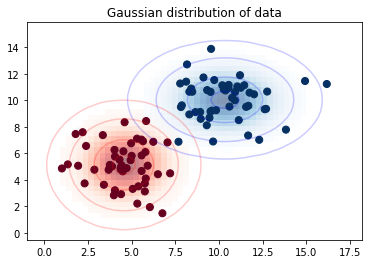

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

xlim = (min(X[:, 0])-2, max(X[:, 0])+2)
ylim = (min(X[:, 1])-2, max(X[:, 1])+2)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu)**2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5, cmap=color.title()+'s')
    ax.contour(xx, yy, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)
plt.title('Gaussian distribution of data')
plt.show()

**STEP 4**: Let's test the inference procedure on the test data.
- Let's get the class predictions on test data.

In [20]:
gaussian_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

Generate a classification report- containing information about different classification evaluation metrics like precision, recall, F-1 score and accuracy.

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gaussian_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



- Let's get the probability of each example belonging to each class.

In [22]:
gaussian_nb._prod_likelihood_prior

array([[ -4.91052542, -20.09590275],
       [-37.47097638,  -7.26785437],
       [ -9.92068673,  -4.45946415],
       [ -3.30751332, -14.52883493],
       [-16.06690366,  -4.20551822],
       [ -3.58403824, -12.20956333],
       [ -5.71017062,  -9.27740851],
       [ -3.84882391, -14.77632486],
       [-15.13765094,  -4.67526161],
       [-19.90771393,  -3.80833058],
       [ -6.2209101 ,  -7.26235683],
       [ -3.73527295, -12.21997798],
       [ -5.14861666, -21.43307717],
       [-16.32039345,  -5.51657426],
       [-22.54117227,  -3.98832875],
       [-13.77146457,  -4.13219482],
       [-13.07064923,  -3.78528848],
       [-22.71346643,  -4.01575954],
       [-10.62494283,  -4.31659727],
       [ -4.91890346, -16.06330422]])

In [23]:
gaussian_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

- Let's make a prediction for a new data point.

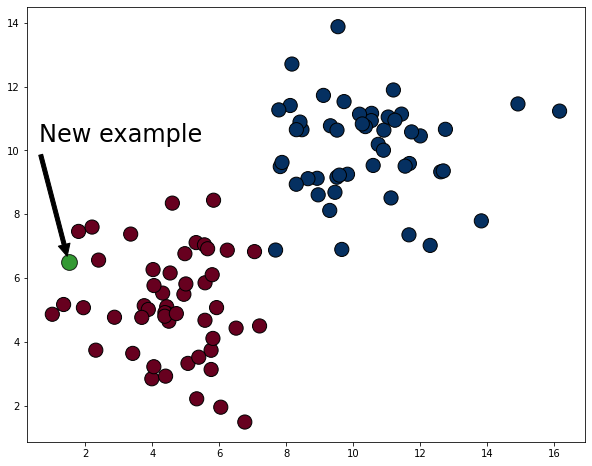

In [24]:
x_new = np.array([1.5, 6.5])

plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], marker='o', c=y, s=200, edgecolors='k', cmap='RdBu')

plt.scatter(x_new[0], x_new[1], marker='o', c='green', s=250, edgecolors='k', alpha=0.8)
plt.annotate('New example', xy=x_new, xytext=(-30,120),
            textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05), fontsize=24)
plt.show()

Since the data point is close to Gaussian distribution with mean [5,5], we will get the label of that class.

In [25]:
gaussian_nb.predict_proba(np.array([x_new]))

array([[9.99996296e-01, 3.70449944e-06]])

Observe that the probability of the new example belonging to class 0, which has mean of [5,5] is 0.99, much larger than the other class and hence it is assigned class label 0.

### Multiclass classification
Our implementation also works for multi-class case. Here's the demo.
- We generate 100 examples from three classes with means [5, 5],[10, 10] and [20, 20].
- Each example has two features.

In [26]:
# generate synthetic data with three classes
# Each example is represented with two features
X, y = make_blobs(n_samples = 100,
                  n_features = 2,
                  centers = [[5,5],[10,10], [20, 20]],
                  cluster_std = 1.5,
                  random_state = 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Let's estimate the parameters of Gaussian distributions.

In [27]:
gaussian_nb_multiclass = GaussianNB()
gaussian_nb_multiclass.fit(X_train, y_train)

Mean:  [[ 4.94844927  4.67947138]
 [ 9.62097704 10.49990402]
 [19.63832097 19.94706375]]
Variance:  [[1.99332345 2.36976247]
 [1.68415535 2.25596351]
 [1.79203315 1.24939267]]
Priors:  [0.3375 0.35   0.3125]


Let's use the estimated parameters to make prediction on test examples and generate the classification report

In [28]:
print(classification_report(y_test, gaussian_nb_multiclass.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Finally predict probability of each test example belonging to three different classes.

In [29]:
gaussian_nb_multiclass.predict_proba(X_test)

array([[1.02996770e-47, 2.67740135e-24, 1.00000000e+00],
       [5.00111567e-05, 9.99949989e-01, 6.51529293e-32],
       [9.99999999e-01, 9.45325297e-10, 1.33290144e-78],
       [1.00000000e+00, 6.49743430e-12, 7.70260328e-90],
       [1.50617094e-52, 5.94123831e-27, 1.00000000e+00],
       [3.77917160e-47, 9.99218112e-23, 1.00000000e+00],
       [5.30598294e-33, 9.05195020e-13, 1.00000000e+00],
       [6.63950534e-07, 9.99999336e-01, 1.42699786e-26],
       [3.57244754e-61, 3.86494439e-34, 1.00000000e+00],
       [9.70872284e-06, 9.99990291e-01, 5.02104511e-31],
       [9.99982252e-01, 1.77477098e-05, 2.51366893e-63],
       [3.93493321e-39, 5.51495730e-18, 1.00000000e+00],
       [1.00000000e+00, 4.72574372e-11, 1.19906531e-79],
       [1.19575291e-47, 3.45203067e-24, 1.00000000e+00],
       [9.09245241e-01, 9.07547595e-02, 1.30885257e-46],
       [9.99999997e-01, 2.64110663e-09, 3.37901343e-80],
       [9.97572472e-01, 2.42752753e-03, 1.17514148e-55],
       [1.12896485e-05, 9.99988

## Lecture 6.5: Multinomial Naive Bayes Implementation
### Multinomial NB
We use the **Multinomial Naive Bayes classifier** for problems like **document classification**.
- We represent the $i$-th document with a feature vector $\textcolor{blue}{\mathbf{x}^{(i)}}$ containing counts of words in the vocabulary $\textcolor{blue}{\{x_1^{(i)}, x_2^{(i)}, x_3^{(i)},...,x_m^{(i)} \}}$
- The sum of all features counts is equal to the total number of words in the document: $\textcolor{blue}{\sum_{j=1}^m x_j^{(i)} = l}$

In mathematical terms:
$$
\large
\begin{align}
    \mathbf{x} | y_r &\sim \text{Multinomial}(w_{1y_r}, w_{2y_r},...,w_{my_r}) \\
    &\sim \text{Multinomial}(\mathbf{w_{y_r}})
\end{align}
$$
> The **total number of parameters** $\textcolor{blue}{= m \times k + k}$ where
>  - $m \times k$ is the total number of features for $k$ multinomial distributions and 
>  - $k$ is the total number of priors

### Parameter estimation
The $j$-th component of parameter vector $\mathbf{w_{y_r}}$ for **multinomial distribution** of class y_r is calculated as follows:
$$
\large
w_{jy_r} = \frac{\textcolor{blue}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)x_j^{(i)}}}{\textcolor{red}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)\sum_{j=1}^m x_j^{(i)}}}
$$
Here,
- The numerator is **sum of feature** $x_j$ for **all examples** from class $y_r$.
- The denominator is the total count of features from all the examples from class $y_r$.

With **Laplace Correction**:
$$
\large
w_{jy_r} = \frac{\textcolor{blue}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)x_j^{(i)}} + \alpha}{\textcolor{red}{\sum_{i=1}^n \mathbb{1}(y^{(i)} = y_r)\sum_{j=1}^m x_j^{(i)}} + m\alpha}
$$
Note that we add $\alpha$ in the numerator and $m\alpha$ in the denominator, correction of $\alpha$ for every feature.
> Since we are using Laplace correction, $\alpha = 1$

### Inference
In log space the calculation is performed as follows:
- In the numerator, we first **multiply** the **count matrix** with **transpose of log of weight vector** and **add** to the **log of prior probabilities**. And **exponentiate** the resulting value.
- In the denominator, we perform the same calculation as numerator but for **different class labels**. And then **sum** them up.
- The denominator normalizes numerator between 0 and 1m thus giving  us the posterior probability of label $y_c$ for the given count vector $\mathbf{x}$.
$$
\large
p(y_c|\mathbf{x};l, \mathbf{w_{y_c}}) = \frac{\exp \left(\mathbf{X}(\log \mathbf{w_{y_c}})^T + \log p(y_c) \right)}{\sum_r \exp \left(\mathbf{X}(\log \mathbf{w_{y_r}})^T + \log p(y_r) \right)}
$$

### Implementation

In [30]:
class MultinomialNB (object):    
    def fit(self, X, y, alpha=1):
        '''
        Implements the parameter estimation for multinomial NB
        '''
        n_samples , n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate the parameters of k multinomial distributions and priors
        self.w = np.zeros((n_classes, n_features), dtype = np.float64)
        self.w_priors = np.zeros(n_classes, dtype = np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            
            # Get the total count of features for class c.
            total_count = np.sum(np.sum(X_c, axis=1))

            # Estimate the parametes of multinomial distribution for class c
            self.w[idx, :] = (np.sum(X_c, axis=0) + alpha)/(total_count + alpha * n_features)

            # Estimate the class prior for class c.
            self.w_priors[idx] = (X_c.shape[0] + alpha)/float(n_samples * alpha + n_classes)
        
    def log_likelihood_prior_prod(self, X):
        '''
        Calculates log of product of likelihood and prior
        '''
        return X @ (np.log(self.w).T) + np.log(self.w_priors)
    
    def predict(self, X):
        '''
        predicts class for input examples.
        '''
        return np.argmax(self.log_likelihood_prior_prod(X), axis=1)
    
    def predict_proba(self, X):
        '''
        Calculates the probability of examples belonging to different classes.
        '''
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q)/np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)

### Demo
Our implementation works for both binary as well as multi-class settings.

### Binary Setup
Generate the synthetic data for two classes and each example with 5 features

In [31]:
rng = np.random.RandomState(1)
X = rng.randint(5, size=(1000, 5))
y = rng.randint(2, size=(1000, ))

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
print('Shape of feature matrix:', X_train.shape)
print('Shape of label vector:', y_train.shape)

Shape of feature matrix: (750, 5)
Shape of label vector: (750,)


Estimate the parameters of multinomial NB

In [33]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

# Examine the parameters of multinomial NB
print('Prior:', multinomial_nb.w_priors)
print('Parameters of multinomial distribution: \n', multinomial_nb.w)

Prior: [0.48138298 0.51861702]
Parameters of multinomial distribution: 
 [[0.21696801 0.18331015 0.19721836 0.19694019 0.20556328]
 [0.20962459 0.19803477 0.19753086 0.20080625 0.19400353]]


Observe that
- Each class is equally likely- each class has a probability of 0.5
- Sum of probabilities of different features for each class is 1.

Let's evalute the classifier:

In [34]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.33      0.41       124
           1       0.53      0.73      0.61       126

    accuracy                           0.53       250
   macro avg       0.54      0.53      0.51       250
weighted avg       0.54      0.53      0.51       250



The lower values of precision and recall is due to random assignment of labels in the synthetic data.

Let's calculate the probability of each example belonging to both the classes.

In [35]:
multinomial_nb.predict_proba(X_test[:5])

array([[0.49996853, 0.50003147],
       [0.44208762, 0.55791238],
       [0.46741708, 0.53258292],
       [0.54002237, 0.45997763],
       [0.47019516, 0.52980484]])

### MultiClass setup
Let's generate data for 3 classes.

In [36]:
rng = np.random.RandomState(1)
X = rng.randint(5, size=(1000, 5))
y = rng.randint(3, size=(1000, ))

X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's estimate the parameters of multinomial naive bayes classifier.

In [37]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

# Examine the parameters of multinomial NB
print('Prior:', multinomial_nb.w_priors)
print('Parameters of multinomial distribution: \n', multinomial_nb.w)

Prior: [0.3439575  0.3439575  0.31208499]
Parameters of multinomial distribution: 
 [[0.21388155 0.19841569 0.18860807 0.19803848 0.20105621]
 [0.21644162 0.18824464 0.19499603 0.19936458 0.20095314]
 [0.21660346 0.20016856 0.19131901 0.20269701 0.18921197]]


Let's evaluate the classifier we have learnt

In [38]:
print(classification_report(y_test, multinomial_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.39      0.46      0.42        89
           1       0.38      0.54      0.44        84
           2       0.32      0.10      0.16        77

    accuracy                           0.38       250
   macro avg       0.36      0.37      0.34       250
weighted avg       0.36      0.38      0.35       250



The lower values of precision and recall is due to random assignment of labels in the synthetic data.

Finally predict probability for test examples belonging to different classes.

In [39]:
multinomial_nb.predict_proba(X_test[:5])

array([[0.34557913, 0.36551273, 0.28890814],
       [0.30429314, 0.3552746 , 0.34043226],
       [0.35677682, 0.33966033, 0.30356285],
       [0.36804952, 0.33094367, 0.3010068 ],
       [0.35566394, 0.33080787, 0.31352819]])